In [1]:
import math
import copy
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import clear_output, display
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import fft, signal
sns.set(style="darkgrid")
%config IPCompleter.greedy = True
%config Completer.use_jedi = False
sns.mpl.rc('figure',figsize=(20, 6))

In [2]:
%run 8.1-forecasting-methods.ipynb

In [3]:
data_load_second_interval = 5
minute_interval = 1

In [4]:
resample_second_interval = 60 #120 #60

In [5]:
resample_minutes = resample_second_interval / 60

In [6]:
hour_observations = int(60/resample_minutes)
half_hour_observations = int(hour_observations/2)
day_observations = int(60/resample_second_interval*60*24)
three_day_observations = int(60/resample_second_interval*60*24*3)
week_observations = int(60/resample_second_interval*60*24*7)

#### Load data

In [7]:
data = pd.read_csv(f"../../data/corrected_m2/corrected_data_2_{minute_interval}m_{data_load_second_interval}s.csv")
data['ndt'] = pd.to_datetime(data['ndt'])

In [8]:
sea = pd.read_csv(f"../../data/seasonal.csv")

In [9]:
intervals = pd.read_csv("../../data/testing_training_intervals.csv")

In [10]:
sea_data = data[data['hash'].isin(sea['hash'])].groupby('ndt').sum()

In [11]:
sea_data = sea_data.resample(f'{resample_second_interval}S').sum()

In [70]:
forecast_observations = 30

#### Forecast anomaly free data

In [12]:
anomaly_free_data = sea_data.copy()

In [13]:
pd.options.mode.chained_assignment = None 

def mean_range(data, start, end):
    past_start = pd.Timestamp(start) - pd.Timedelta(days=1)
    past_end = pd.Timestamp(end) - pd.Timedelta(days=1)
    future_start = pd.Timestamp(start) + pd.Timedelta(days=1)
    future_end = pd.Timestamp(end) + pd.Timedelta(days=1)
    new_vals = data.loc[past_start:past_end]['count'].values + data.loc[future_start:future_end]['count'].values / 2
    data.loc[start:end]['count'] = new_vals
    return data

In [56]:
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-22 12:20:00','2019-07-22 13:00:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-22 08:00:00','2019-07-22 08:13:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-22 13:45:00','2019-07-22 14:07:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-24 12:58:00','2019-07-24 13:18:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-29 12:20:00','2019-07-29 12:53:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-08-01 12:58:00','2019-08-01 14:30:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-08-02 14:20:00','2019-08-02 14:59:00')

<AxesSubplot:xlabel='ndt'>

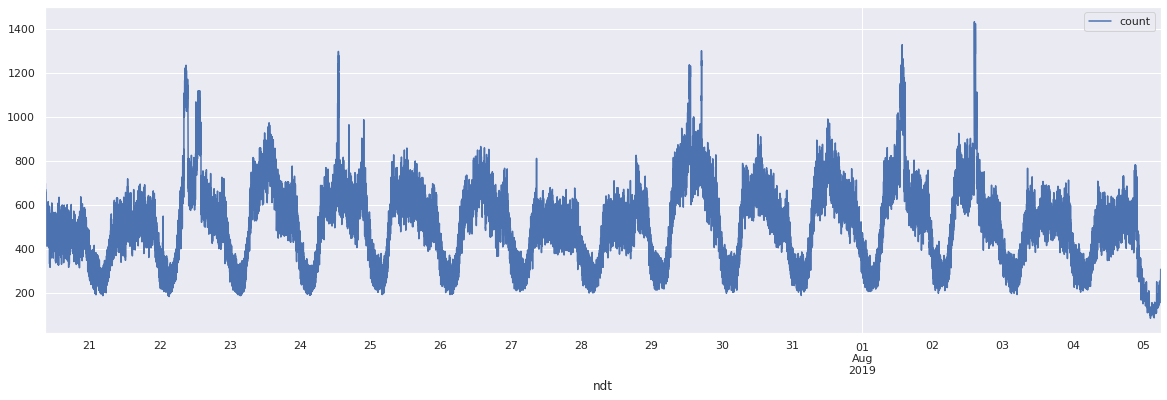

In [58]:
anomaly_free_data['2019-07-20 08:45:00':].plot()

# Time Series Components #

In [12]:
stl = STL(sea_data, period=int(day_observations), seasonal=7)
res = stl.fit()

[]

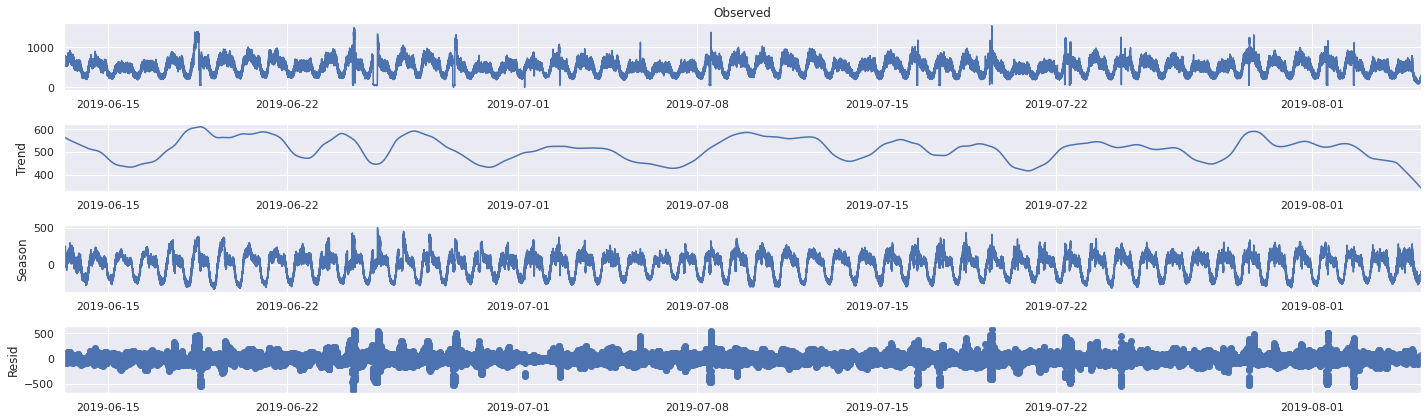

In [13]:
#fig = plt.figure(figsize=(20,20))
res.plot()
plt.plot()

# Stationarity and differencing #

In [14]:
sea_data_diff = sea_data.diff().dropna() 
sea_data_sdiff = sea_data_diff.diff().dropna()
sea_data_sea_diff = sea_data.diff(day_observations).dropna()
sea_data_sea_diff_diff = sea_data_sea_diff.diff().dropna()

## Unmodified data ##

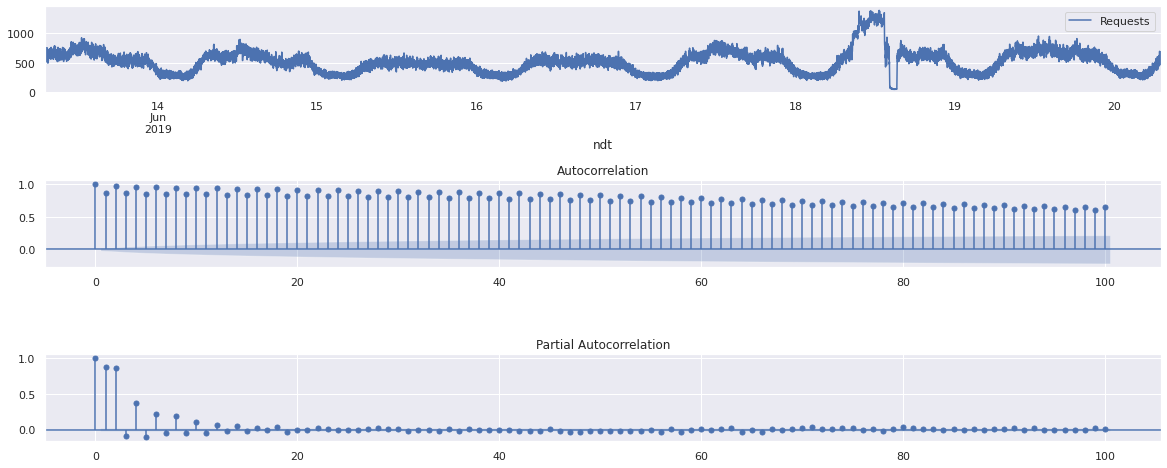

In [15]:
plot_data_stationarity(sea_data[:week_observations])

In [16]:
kpss_test(sea_data)

Results of KPSS Test:
Test Statistic             0.171776
p-value                    0.100000
Lags Used                162.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Fail to reject null the hypothesis (data is stationary).

In [17]:
adf_test(sea_data)

Results of Dickey-Fuller Test:
Test Statistic                -1.247327e+01
p-value                        3.209535e-23
#Lags Used                     6.300000e+01
Number of Observations Used    7.619600e+04
Critical Value (1%)           -3.430436e+00
Critical Value (5%)           -2.861578e+00
Critical Value (10%)          -2.566790e+00
dtype: float64


* https://otexts.com/fpp2/stationarity.html#unit-root-tests

## First difference ##

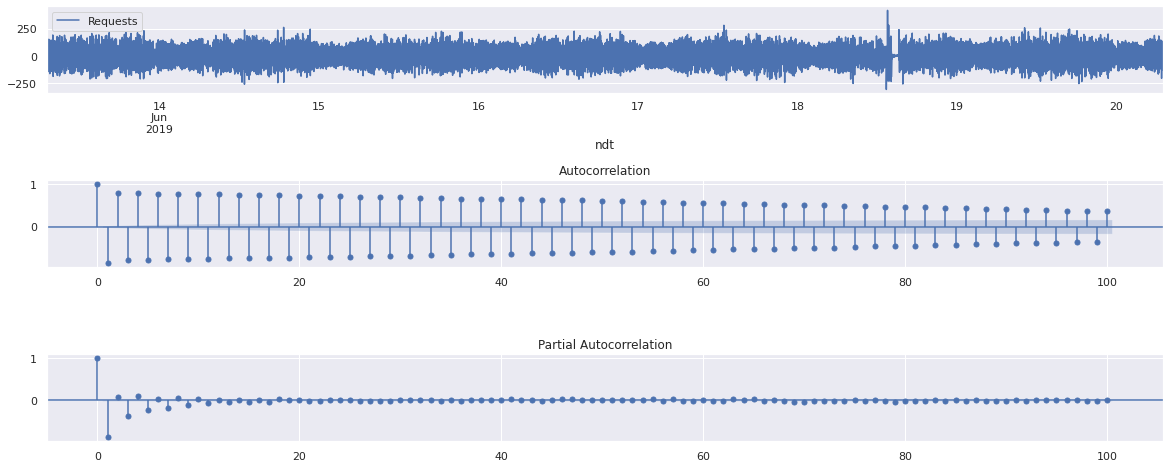

In [18]:
plot_data_stationarity(sea_data_diff[:week_observations])

In [19]:
kpss_test(sea_data_diff)

Results of KPSS Test:
Test Statistic             0.002761
p-value                    0.100000
Lags Used                240.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [20]:
adf_test(sea_data_diff)

Results of Dickey-Fuller Test:
Test Statistic                   -39.626615
p-value                            0.000000
#Lags Used                        64.000000
Number of Observations Used    76194.000000
Critical Value (1%)               -3.430436
Critical Value (5%)               -2.861578
Critical Value (10%)              -2.566790
dtype: float64


## Second difference ##

/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


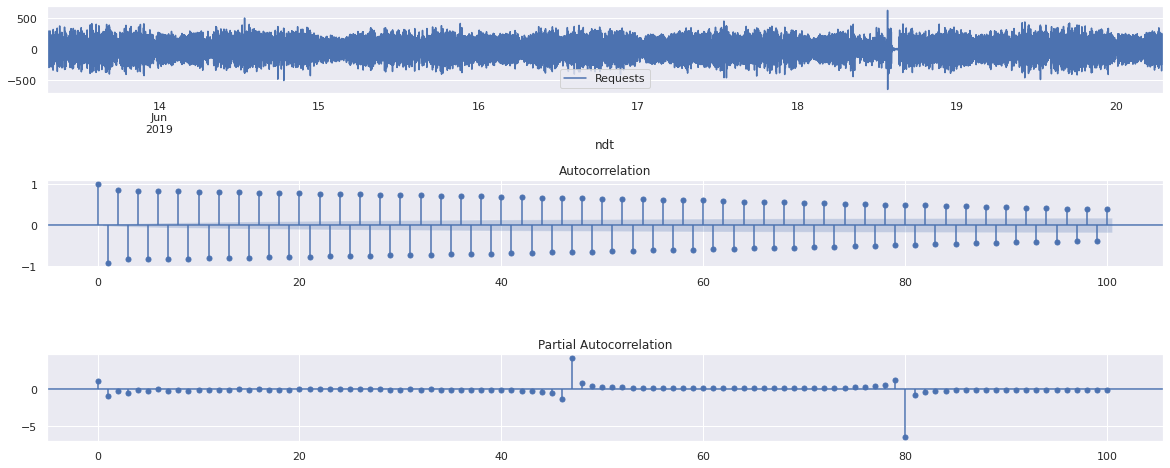

In [21]:
plot_data_stationarity(sea_data_sdiff[:week_observations])

In [22]:
kpss_test(sea_data_sdiff)

Results of KPSS Test:
Test Statistic             0.001311
p-value                    0.100000
Lags Used                251.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [23]:
adf_test(sea_data_sdiff)

Results of Dickey-Fuller Test:
Test Statistic                   -64.283185
p-value                            0.000000
#Lags Used                        64.000000
Number of Observations Used    76193.000000
Critical Value (1%)               -3.430436
Critical Value (5%)               -2.861578
Critical Value (10%)              -2.566790
dtype: float64


## Seasonal difference ##

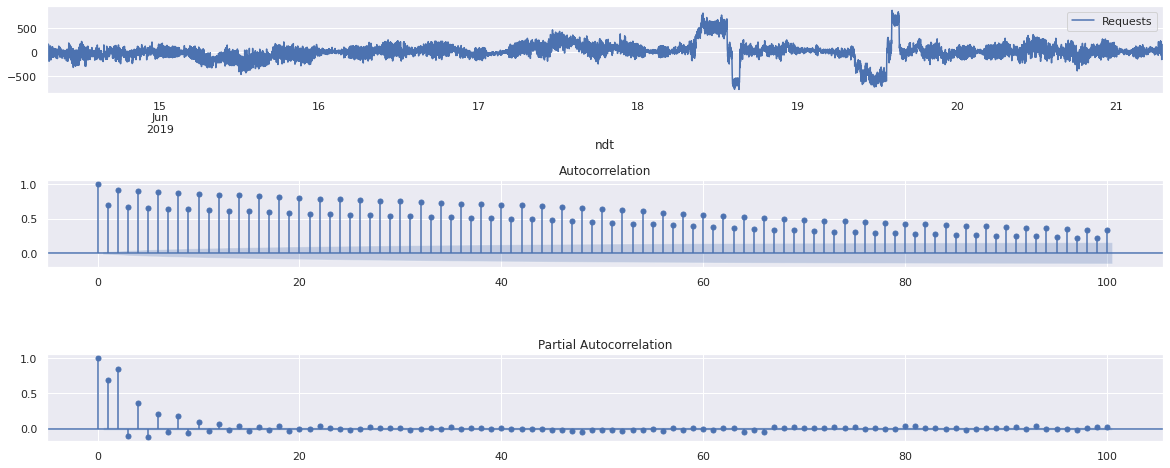

In [24]:
plot_data_stationarity(sea_data_sea_diff[:week_observations])

In [25]:
kpss_test(sea_data_sea_diff)

Results of KPSS Test:
Test Statistic             0.083999
p-value                    0.100000
Lags Used                158.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [26]:
adf_test(sea_data_sea_diff)

Results of Dickey-Fuller Test:
Test Statistic                   -20.068575
p-value                            0.000000
#Lags Used                        57.000000
Number of Observations Used    74762.000000
Critical Value (1%)               -3.430437
Critical Value (5%)               -2.861579
Critical Value (10%)              -2.566791
dtype: float64


# Forecasting #

## Test and training split ##

In [59]:
timespan_start = data['ndt'].min()
training_timestamp = pd.date_range(start=timespan_start, end='2019-07-20 08:42:00', freq=f'{resample_second_interval}S')
training_split = len(sea_data.loc[:training_timestamp[-1]]) #int(len(sea_data)*0.7) # 70%
k_fold_step = int(60/resample_second_interval*60*1) # 1 Hours ahead

In [60]:
training_split

53383

In [61]:
sea_data.index[0]

Timestamp('2019-06-13 07:00:00', freq='60S')

In [62]:
sea_data.index[-1]

Timestamp('2019-08-05 05:59:00', freq='60S')

In [63]:
sea_data.index[training_split] 

Timestamp('2019-07-20 08:43:00', freq='60S')

In [64]:
sea_data.index[training_split] - sea_data.index[0]

Timedelta('37 days 01:43:00')

## Naive Method

In [ ]:
naive_mod = naive_method(sea_data[:training_split])

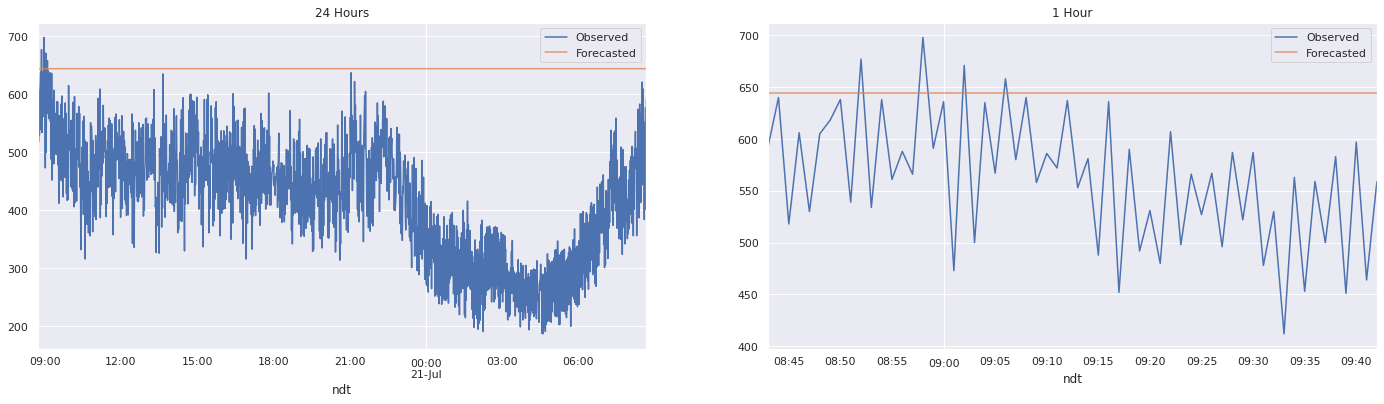

In [35]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("1 Hour")
showcase_zoom(sea_data[training_split:training_split+day_observations], pd.Series(naive_mod.forecast(day_observations)), ax[0])
showcase_zoom(sea_data[training_split:training_split+hour_observations], pd.Series(naive_mod.forecast(hour_observations)), ax[1])

In [39]:
naive_mod_forecasts = forecast_n_steps(sea_data, naive_mod, training_split, half_hour_observations, end=training_split+day_observations)

Text(0.5, 1.0, '"Live" - 30 Minutes ahead forecasts as new observations are added.')

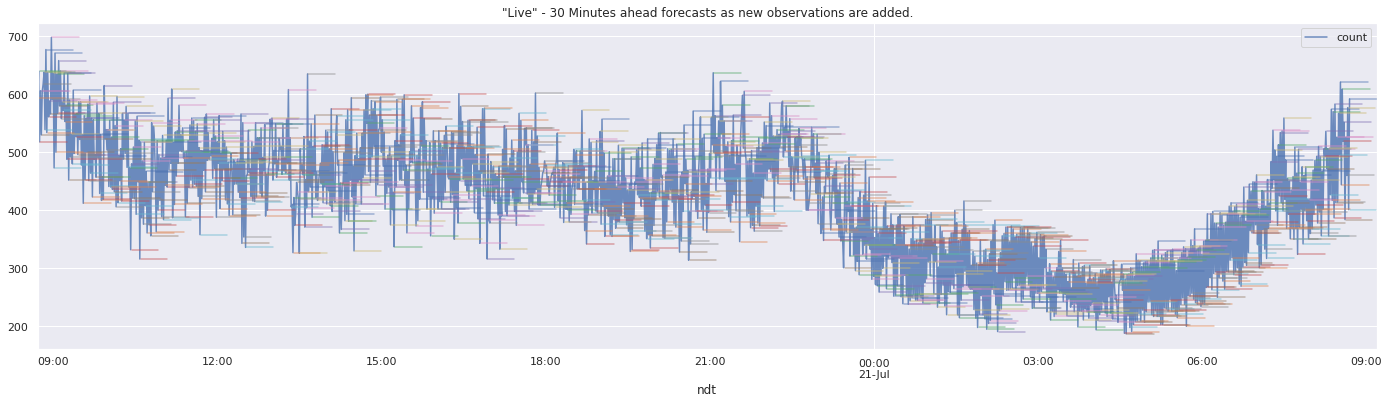

In [42]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
sea_data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in naive_mod_forecasts[1].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=30),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title("\"Live\" - 30 Minutes ahead forecasts as new observations are added.")

In [85]:
_, naive_errors = error_n_steps(sea_data, naive_mod, training_split, half_hour_observations)

## Average method

In [ ]:
average_method_mod = average_method(sea_data[:training_split], 15)

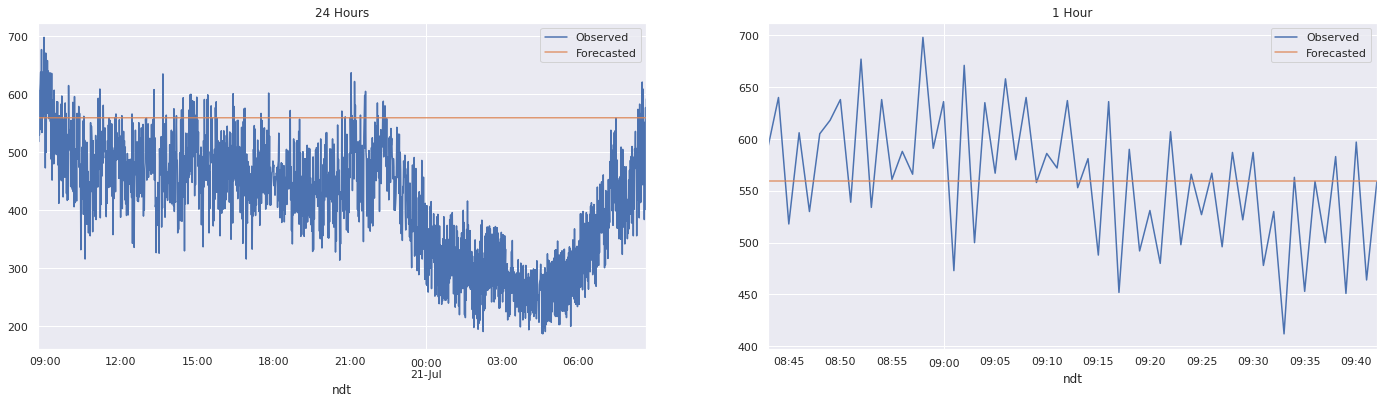

In [45]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("1 Hour")
showcase_zoom(sea_data[training_split:training_split+day_observations], pd.Series(average_method_mod.forecast(day_observations)), ax[0])
showcase_zoom(sea_data[training_split:training_split+hour_observations], pd.Series(average_method_mod.forecast(hour_observations)), ax[1])

In [46]:
average_method_forecasts = forecast_n_steps(sea_data, average_method_mod, training_split, half_hour_observations, end=training_split+day_observations)

Text(0.5, 1.0, '"Live" - 30 Minutes ahead forecasts as new observations are added.')

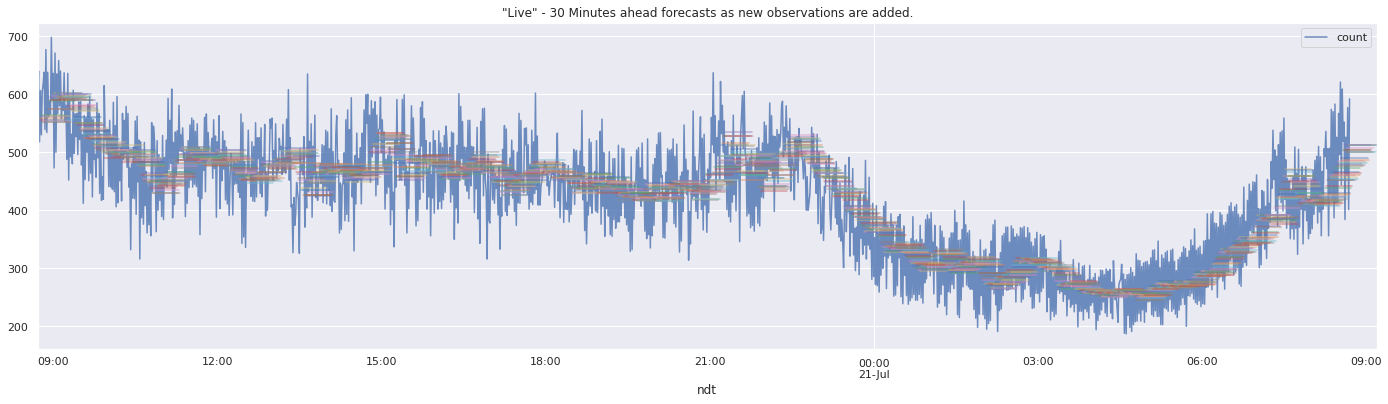

In [47]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
sea_data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in average_method_forecasts[1].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=30),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title("\"Live\" - 30 Minutes ahead forecasts as new observations are added.")

In [86]:
_, average_errors = error_n_steps(sea_data, average_method_mod, training_split, half_hour_observations)

## Seasonal Naive Method (24-hour)

In [ ]:
seasonal_naive_mod = seasonal_naive_method(sea_data[:training_split], day_observations)

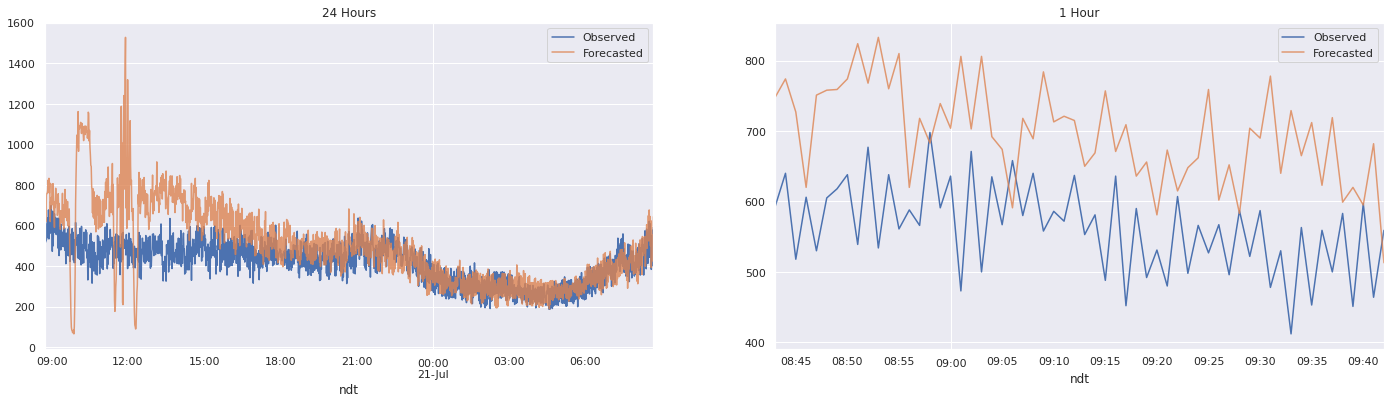

In [49]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("1 Hour")
showcase_zoom(sea_data[training_split:training_split+day_observations], pd.Series(seasonal_naive_mod.forecast(day_observations)), ax[0])
showcase_zoom(sea_data[training_split:training_split+hour_observations], pd.Series(seasonal_naive_mod.forecast(hour_observations)), ax[1])

In [50]:
seasonal_naive_forecasts = forecast_n_steps(sea_data, seasonal_naive_mod, training_split, half_hour_observations, end=training_split+day_observations)

Text(0.5, 1.0, '"Live" - 30 Minutes ahead forecasts as new observations are added.')

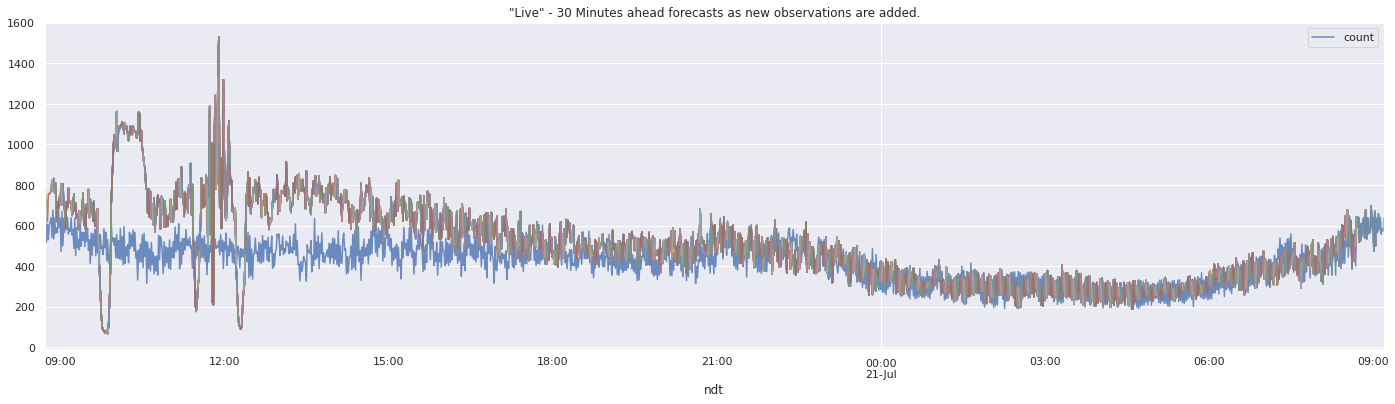

In [51]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
sea_data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in seasonal_naive_forecasts[1].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=30),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title("\"Live\" - 30 Minutes ahead forecasts as new observations are added.")

In [87]:
_, seasonal_naive_errors = error_n_steps(sea_data, seasonal_naive_mod, training_split, half_hour_observations)

## AR(1)

In [ ]:
#https://www.statsmodels.org/dev/examples/notebooks/generated/autoregressions.html

In [ ]:
ar_1_mod = sm.tsa.SARIMAX(sea_data[:training_split], order=(1,0,0), trend='c')
ar_1_res = ar_1_mod.fit()

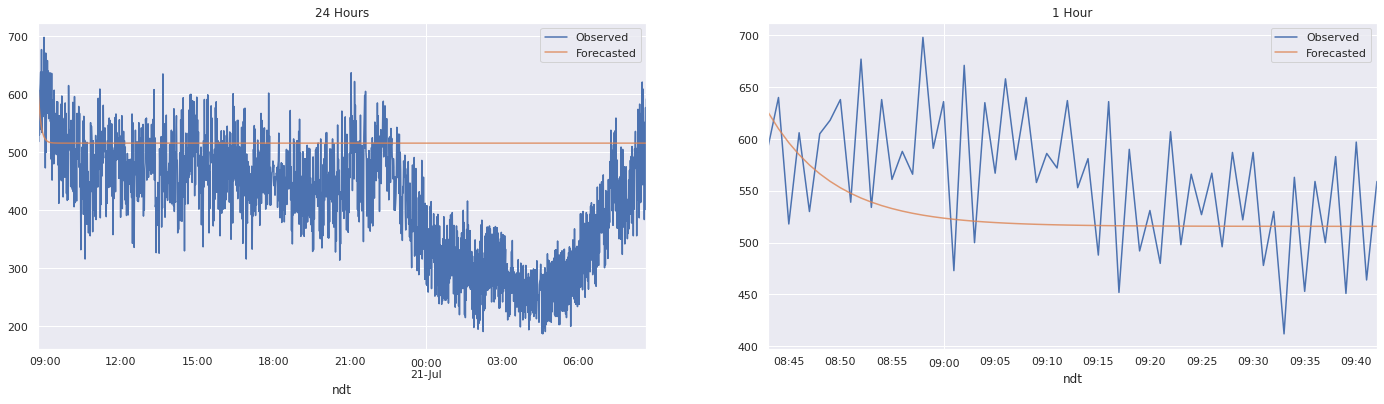

In [53]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("1 Hour")
showcase_zoom(sea_data[training_split:training_split+day_observations], pd.Series(ar_1_res.forecast(day_observations)), ax[0])
showcase_zoom(sea_data[training_split:training_split+hour_observations], pd.Series(ar_1_res.forecast(hour_observations)), ax[1])

In [54]:
ar_1_forecasts = forecast_n_steps(sea_data, ar_1_res, training_split, half_hour_observations, end=training_split+day_observations)

Text(0.5, 1.0, '"Live" - 30 Minutes ahead forecasts as new observations are added.')

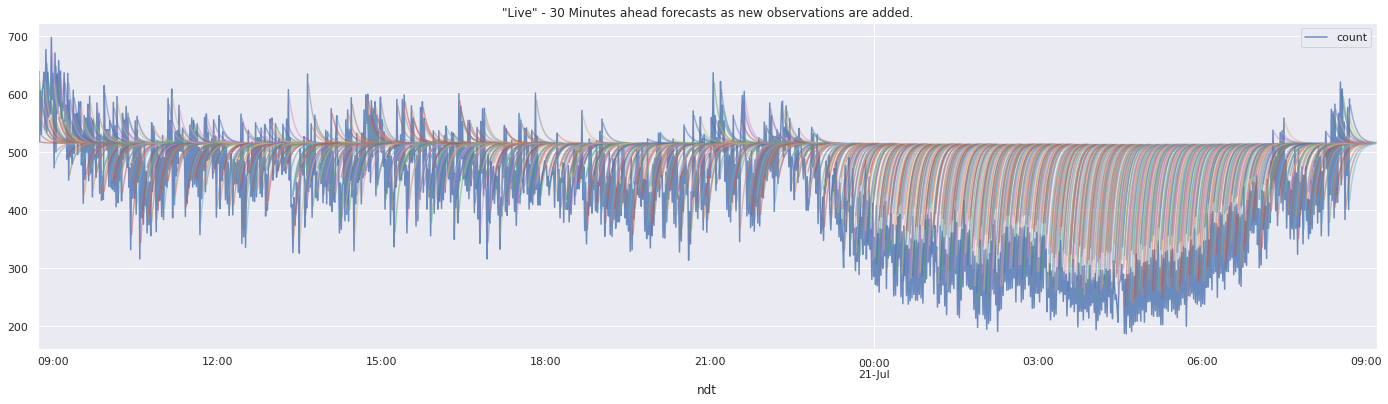

In [55]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
sea_data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in ar_1_forecasts[1].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=30),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title("\"Live\" - 30 Minutes ahead forecasts as new observations are added.")

In [88]:
_, ar1_errors = error_n_steps(sea_data, ar_1_res, training_split, half_hour_observations)

In [ ]:
#ar_1_mse_horizon, ar_1_rmse_horizon = rmse_horizons(ar_1_errors)

## ARIMA with Fourier Terms

In [62]:
from pmdarima.preprocessing import FourierFeaturizer
import pmdarima as pm

In [ ]:
resulting_models = []
for d_k in range(1, 12):
        daily_transformation = FourierFeaturizer(m=day_observations, k=d_k)
        _, exog_d = daily_transformation.fit_transform(sea_data[:training_split])
        print(d_k)
        ft_fit = pm.auto_arima(sea_data[:training_split],
                             start_q = 2,
                             max_q = 20,
                             start_p = 2,
                             max_p = 20,
                             D = None,
                             exogenous=exog_d,
                             max_order = 30,
                             maxiter = 28,
                             seasonal = False,
                             information_criterion = 'aic',
                             stepwise = True, # n_jobs = 16
                             trace = 3,
                             cov_type=None
                            )
        resulting_models.append(ft_fit)

In [ ]:
resulting_models

In [ ]:
smallest_aic = min(resulting_models, key=lambda x: x.aic())

In [ ]:
smallest_aic.summary()

In [ ]:
print(smallest_aic, smallest_aic.aic())

In [27]:
# K = 8

### Selected model

In [65]:
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.api import SARIMAX

In [66]:
fourier_dp = DeterministicProcess(anomaly_free_data.index, period=day_observations, fourier=8)
exog_fourier = fourier_dp.in_sample()

In [72]:
exog_fourier = exog_fourier.append(
                fourier_dp.out_of_sample(hour_observations,
                                       forecast_index=pd.date_range(
                                               start=exog_fourier.index[-1]+pd.Timedelta(minutes=1),
                                               periods=hour_observations,
                                               freq=f"{resample_second_interval}S")))

In [73]:
arimax_mod = SARIMAX(sea_data[:training_split], order=(9, 1, 2), exog=exog_fourier[:training_split], trend='c')
arimax_res = arimax_mod.fit()
print(arimax_res.summary())

/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                53383
Model:               SARIMAX(9, 1, 2)   Log Likelihood             -278216.545
Date:                Wed, 07 Apr 2021   AIC                         556491.090
Time:                        20:52:55   BIC                         556748.761
Sample:                    06-13-2019   HQIC                        556571.559
                         - 07-20-2019                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -0.0002      0.001     -0.170      0.865      -0.002       0.002
sin(1,1440)   157.4770      6.675     23.592      0.000     144.394     170.560
cos(1,1440)   -59.7922      8.169     -7.319    

In [42]:
#joblib.dump(arimax_res, open(f'../../models/arimax_sea_{minute_interval}_{resample_second_interval}', 'wb'))

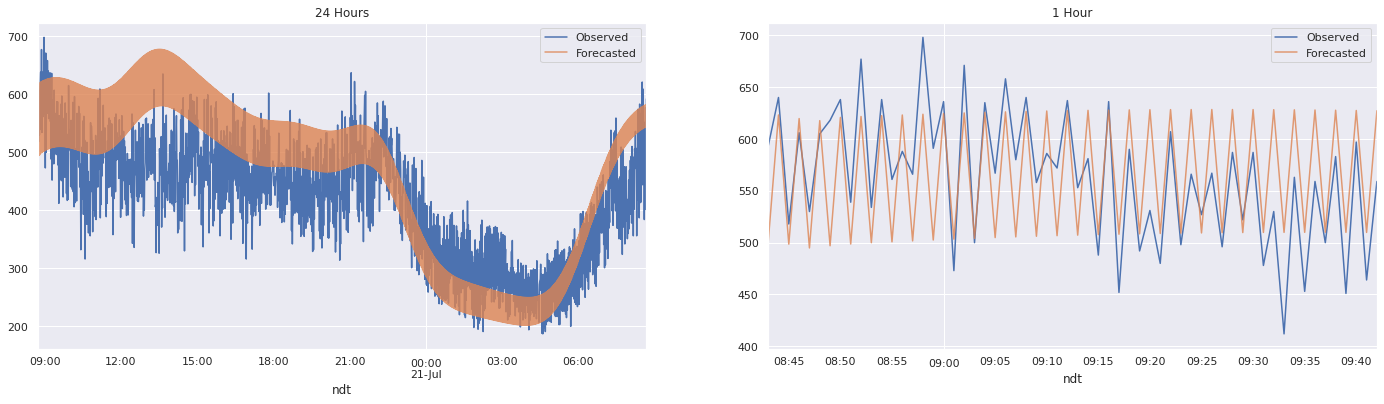

In [43]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("1 Hour")
showcase_zoom(sea_data[training_split:training_split+day_observations],
              pd.Series(arimax_res.forecast(
                    day_observations,
                    exog=exog_fourier[training_split:training_split+day_observations])),
              ax[0])
showcase_zoom(sea_data[training_split:training_split+hour_observations],
              pd.Series(arimax_res.forecast(
                    hour_observations,
                    exog=exog_fourier[training_split:training_split+hour_observations])),
              ax[1])

In [ ]:
arimax_timestamps = []
arimax_forecasts = []
for step in range(training_split, len(anomaly_free_data)):
    clear_output(wait=True)
    print("Step: ", step + 1, "-", len(anomaly_free_data), "; %:", (step + 1)/len(anomaly_free_data), end='\r')
    data_extended = anomaly_free_data[step:step+1]
    arimax_timestamps.append(data_extended.index[0])
    arimax_res = arimax_res.append(data_extended, exog=exog_fourier[step:step+1])
    forecast_exog = exog_fourier[step:step+forecast_observations]
    arimax_forecasts.append(arimax_res.forecast(min(forecast_observations, len(forecast_exog)), exog=forecast_exog).values)
arimax_forecasts = pd.DataFrame(index=arimax_timestamps, data=arimax_forecasts, columns=[f"step_{x}" for x in range(1, forecast_observations+1)])
del arimax_timestamps

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
sea_data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in arimax_forecasts[:day_observations].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=1),
                  end=forecast[0] + pd.Timedelta(minutes=30),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)
ax.set_title("\"Live\" - 30 Minutes ahead forecasts as new observations are added.")

In [ ]:
#arimax_forecasts.to_csv('../../data/forecasts/sea_arimax_forecasts.csv')

In [55]:
arimax_forecasts = pd.read_csv('../../data/forecasts/sea_arimax_forecasts.csv', index_col=0, parse_dates=True)

## TBATS

In [ ]:
#https://github.com/intive-DataScience/tbats

In [50]:
from tbats import TBATS

In [51]:
tbats_mod = TBATS(seasonal_periods=[day_observations], use_box_cox=False)

In [ ]:
tbats_res = tbats_mod.fit(sea_data[:training_split])

In [ ]:
tbats_res.summary()

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("1 Hour")
showcase_zoom(sea_data[training_split:training_split+day_observations], pd.Series(tbats_res.forecast(day_observations)), ax[0])
showcase_zoom(sea_data[training_split:training_split+hour_observations], pd.Series(tbats_res.forecast(hour_observations)), ax[1])

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
sea_data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

vis_tbats = copy.deepcopy(tbats_res)

pd.Series(vis_tbats.forecast(half_hour_observations), index=sea_data.index[training_split:training_split+half_hour_observations]).plot(ax=ax, alpha=0.6)
for i in range(1, day_observations+1): # 24 hour ahead
    vis_tbats.fit(sea_data[:training_split+i])
    pd.Series(vis_tbats.forecast(half_hour_observations), index=sea_data.index[training_split+i:training_split+i+half_hour_observations]).plot(ax=ax, alpha=0.5)
ax.set_title("\"Live\" - 30 Minutes ahead forecasts as new observations are added.")

In [90]:
_, tbats_errors = error_n_steps(sea_data, copy.deepcopy(tbats_res), training_split, half_hour_observations)

## Evaluation ##

In [91]:
arimax_errors = []
for row in arimax_forecasts.iterrows():
    row_timestamp = row[0]
    row_data = row[1]
    observed_data = sea_data.loc[row_timestamp+pd.Timedelta(minutes=1):row_timestamp+pd.Timedelta(minutes=30)]
    #break
    arimax_errors.append((observed_data.values.reshape(1, -1)[0] - row_data[:len(observed_data)].values))
arimax_errors = pd.DataFrame(arimax_errors).fillna(0)

In [92]:
naive_mse, naive_rmse = rmse_forecasts(naive_errors)
average_mse, average_rmse = rmse_forecasts(average_errors)
seasonal_naive_mse, seasonal_naive_rmse = rmse_forecasts(seasonal_naive_errors)
ar1_mse, ar1_rmse = rmse_forecasts(ar1_errors)
arimax_mse, arimax_rmse = rmse_forecasts(arimax_errors)
tbats_mse, tbats_rmse = rmse_forecasts(tbats_errors)

In [93]:
forecast_errors = pd.DataFrame()
forecast_errors['naive_mse'] = naive_mse
forecast_errors['naive_rmse'] = naive_rmse
forecast_errors['average_mse'] = average_mse
forecast_errors['average_rmse'] = average_rmse
forecast_errors['seasonal_naive_mse'] = seasonal_naive_mse
forecast_errors['seasonal_naive_rmse'] = seasonal_naive_rmse
forecast_errors['ar1_mse'] = ar1_mse
forecast_errors['ar1_rmse'] = ar1_rmse
forecast_errors['arimax_mse'] = arimax_mse
forecast_errors['arimax_rmse'] = arimax_rmse
forecast_errors['tbats_mse'] = tbats_mse
forecast_errors['tbats_rmse'] = tbats_rmse

Text(0.5, 1.0, 'Average residua distribution')

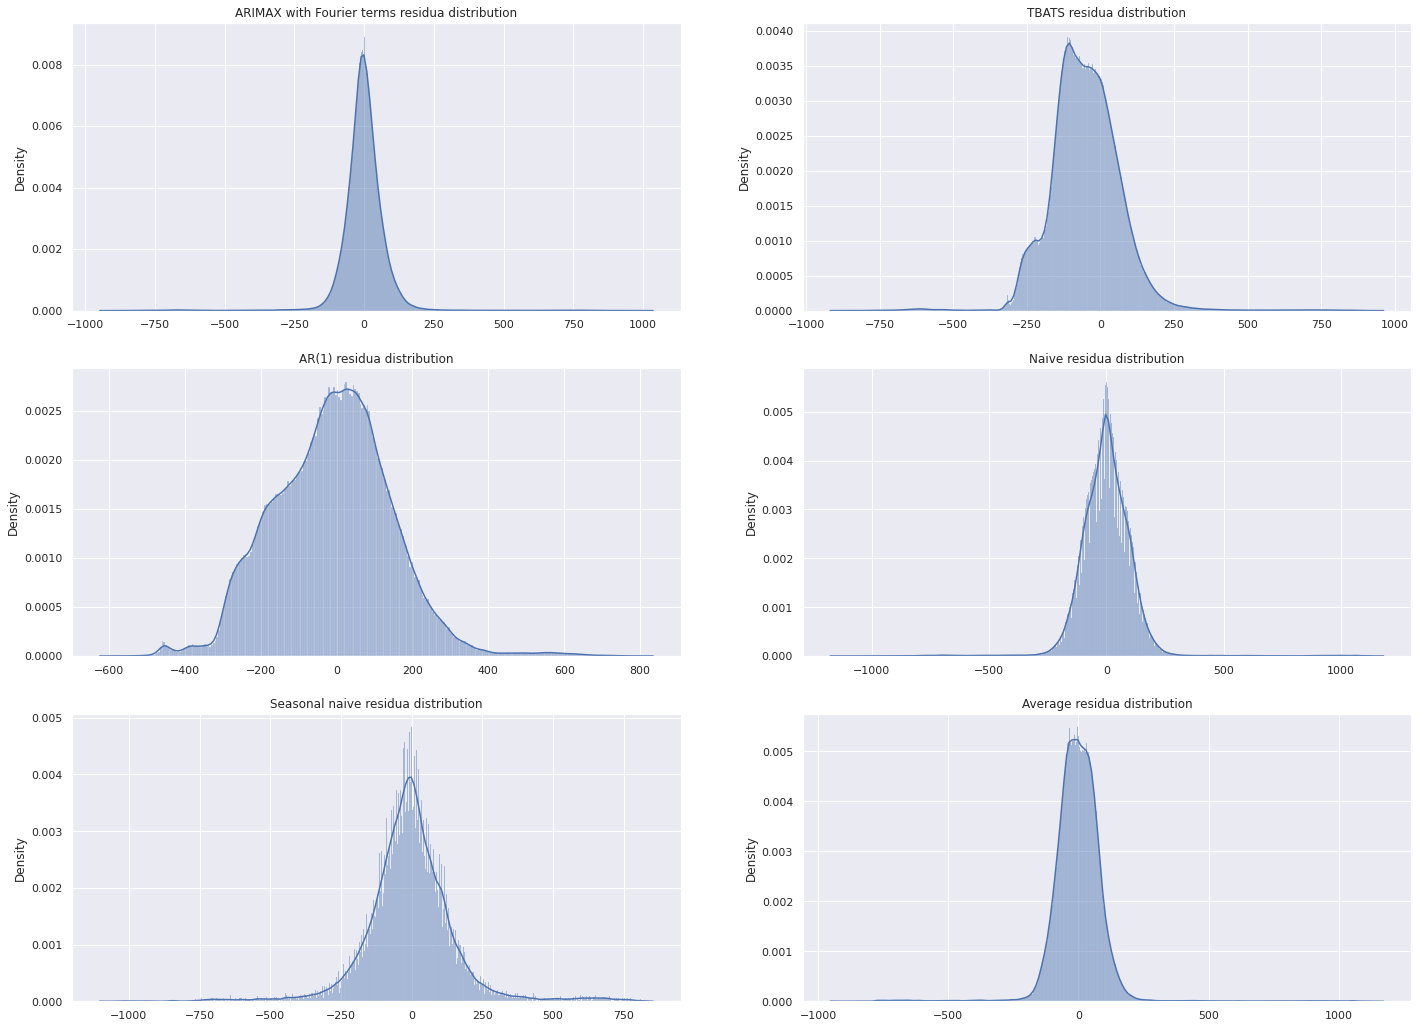

In [78]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(24, 18)

arimax_residues = pd.Series(arimax_errors.values.flatten())
tbats_residues = pd.Series(tbats_errors.values.flatten())
ar1_residues = pd.Series(ar1_errors.values.flatten())
naive_residues = pd.Series(naive_errors.values.flatten())
seasonal_naive_residues = pd.Series(seasonal_naive_errors.values.flatten())
average_residues = pd.Series(average_errors.values.flatten())


sns.histplot(arimax_residues, ax=ax[0][0], stat='density', kde=True)
ax[0][0].set_title("ARIMAX with Fourier terms residua distribution")

sns.histplot(tbats_residues, ax=ax[0][1], stat='density', kde=True)
ax[0][1].set_title("TBATS residua distribution")

sns.histplot(ar1_residues, ax=ax[1][0], stat='density', kde=True)
ax[1][0].set_title("AR(1) residua distribution")

sns.histplot(naive_residues, ax=ax[1][1], stat='density', kde=True)
ax[1][1].set_title("Naive residua distribution")

sns.histplot(seasonal_naive_residues, ax=ax[2][0], stat='density', kde=True)
ax[2][0].set_title("Seasonal naive residua distribution")

sns.histplot(average_residues, ax=ax[2][1], stat='density', kde=True)
ax[2][1].set_title("Average residua distribution")

In [94]:
tbats_rmse.index = sea_data[-len(tbats_mse):].index
arimax_rmse.index = sea_data[-len(arimax_mse):].index
naive_rmse.index = sea_data[-len(naive_rmse):].index
average_rmse.index = sea_data[-len(average_rmse):].index
seasonal_naive_rmse.index = sea_data[-len(seasonal_naive_rmse):].index
ar1_rmse.index = sea_data[-len(ar1_rmse):].index

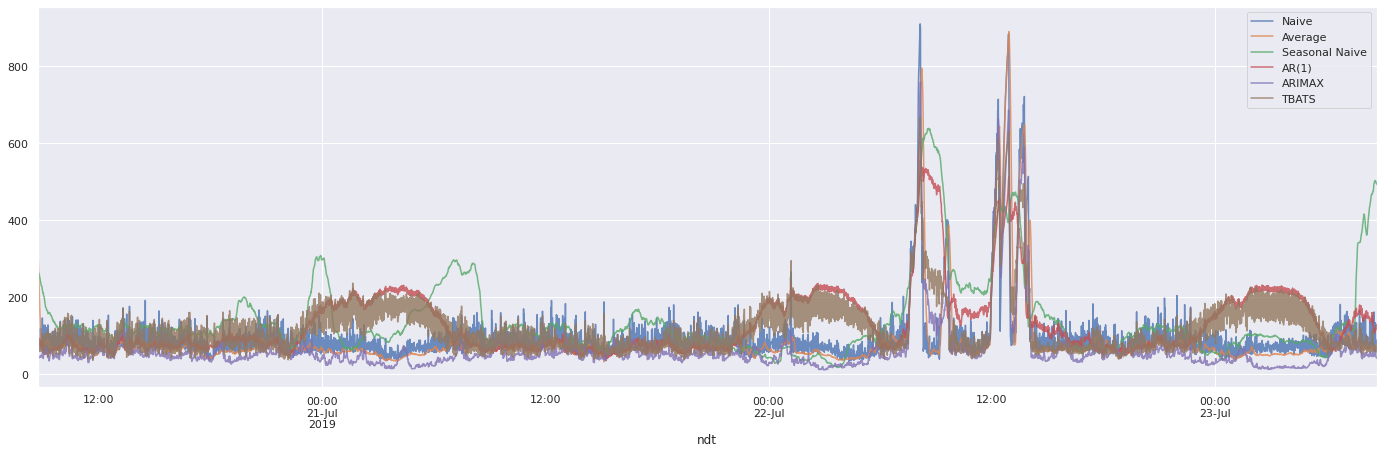

In [95]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 7)

naive_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
average_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
seasonal_naive_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
ar1_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
arimax_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
tbats_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
ax.legend(["Naive", "Average", "Seasonal Naive", "AR(1)", "ARIMAX", "TBATS"])

In [96]:
results = pd.DataFrame(
            data=np.array([
                tbats_rmse.sum(),
                tbats_mse.sum(),
                arimax_rmse.sum(),
                arimax_mse.sum(),
                naive_rmse.sum(),
                naive_mse.sum(),
                seasonal_naive_rmse.sum(),
                seasonal_naive_mse.sum(),
                average_rmse.sum(),
                average_mse.sum(),
                ar1_rmse.sum(),
                ar1_mse.sum(),
            ])
                .reshape(1, -1),
            columns = ['tbats_rmse','tbats_mse',
                       'arimax_rmse','arimax_mse',
                       'naive_rmse', 'naive_mse',
                       'seasonal_naive_rmse', 'seasonal_naive_mse',
                       'average_rmse','average_mse',
                       'ar1_rmse','ar1_mse'])

In [97]:
results

tbats_rmse     tbats_mse   arimax_rmse    arimax_mse    naive_rmse  \
0  2.556683e+06  3.805147e+08  1.360707e+06  1.638472e+08  2.083183e+06   

      naive_mse  seasonal_naive_rmse  seasonal_naive_mse  average_rmse  \
0  2.948882e+08         2.851433e+06        5.796557e+08  1.766614e+06   

    average_mse      ar1_rmse       ar1_mse  
0  2.535785e+08  3.104306e+06  5.436211e+08

In [18]:
len(sea_data[training_split:])

22877

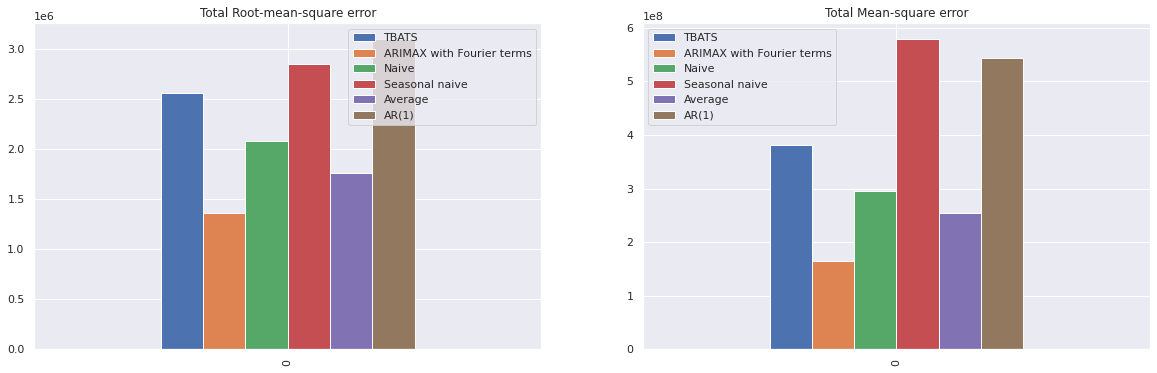

In [98]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)

results[['tbats_rmse', 'arimax_rmse', 'naive_rmse', 'seasonal_naive_rmse', 'average_rmse', 'ar1_rmse']].plot(kind='bar', ax=ax[0])
ax[0].set_title("Total Root-mean-square error")
ax[0].legend(["TBATS", "ARIMAX with Fourier terms", "Naive", "Seasonal naive", "Average", 'AR(1)'])


results[['tbats_mse', 'arimax_mse', 'naive_mse', 'seasonal_naive_mse', 'average_mse', 'ar1_mse']].plot(kind='bar', ax=ax[1])
ax[1].set_title("Total Mean-square error")
ax[1].legend(["TBATS", "ARIMAX with Fourier terms", "Naive", "Seasonal naive", "Average", 'AR(1)'])